# Project 5 - 02 : Models

In [18]:
%pylab inline
import pandas as pd
import os
import warnings
import joblib
import matplotlib.colors as mcolors
import nltk
from random import shuffle
from scipy.sparse import vstack
from sklearn import decomposition
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf
from wordcloud import WordCloud
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

DISPLAY_LDA_VISU = False

Populating the interactive namespace from numpy and matplotlib


D:\Programmes\anaconda3\envs\OC_P5\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vstack', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [11]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 140

## Data import

Duplication of the class used by vectorizers

In [12]:
class TransformTokenizer:
    """ 'All in one' tokenizer. Tokenize and normalize (lemmatize or stem) a text corpus, depending on the given mode
    A RegEx can be used for the tokenisation.
    It's possible to use a custom lemmatizer/stemmer, defaults are WordNetLemmatizer or LancasterStemmer
    It's also possible to remove a custom list of stop words, or nltk stopwords for a given langage
    """
    def __init__(self, mode='lemma', normalizer=None, regex_pattern=None,
                 sw='english', used_postags=[]):
        """
        args:
            mode: {'lemma', 'stem'}, default='lemma' - normalization mode
            transformer: obj default=None - optional custom normalizer
            regexp_pattern: str, default=None - optional regxp for tokenization
            sw_lang: str, default='english' - stop words langage
            rmv_postags: list(str) - unused postags, to remove in the corpus
        """
        if mode and mode not in ['lemma', 'stem']:
            raise ValueError(":mode: must be 'lemma', 'stem' or None only.")
        # defines normalizer (custom or default) depending on the given mode
        self.mode = mode
        self.normalizer = normalizer or WordNetLemmatizer() if self.mode == 'lemma' else lancaster.LancasterStemmer()
        # defines regexptokenizer if pattern
        self.regexptokenizer = nltk.RegexpTokenizer(regex_pattern) if regex_pattern else None
        # defines stop words
        if sw and type(sw) == str:
            self.stop_words = nltk.corpus.stopwords.words(sw)
        elif sw and type(sw) == list:
            self.stop_words = sw
        self.used_postags = used_postags

    def __call__(self, doc):
        """
        args:
            doc: str - text document to tokenize
        output:
            list - tokenized document
        """
        # tokenization
        if self.regexptokenizer:
            tokens = self.regexptokenizer.tokenize(doc)
        else:
            tokens = nltk.word_tokenize(doc)
        # unused POStags removal
        if self.used_postags and tokens:
            postags = nltk.pos_tag(tokens)
            tokens = [x[0] for x in postags if (x[1] in self.used_postags) and (x[0] not in self.stop_words)]
        # Normalisation + stop words removal
        if self.mode == 'lemma':
            tokens = [self.normalizer.lemmatize(tkn) for tkn in tokens]
        elif self.mode == 'stem':
            tokens = [self.normalizer.stem(tkn) for tkn in tokens]
        return tokens

In [13]:
try:
    # load data
    corpus_df = joblib.load("P5_04_data/dataset.pkl")
    # load vectorizers
    corpus_voc, bow_vectorizer, tfidf_vectorizer = joblib.load("P5_04_data/fitted-vectorizers.pkl")
    # load method1 models
    lda_model_gensim = joblib.load("P5_04_data/gensim-lda.pkl")
    nmf_model_gensim = joblib.load("P5_04_data/gensim-nmf.pkl")
    # load method2 models
    # train_tfidf_vectorizer, mlb_tags = joblib.load("P5_04_data/trainset-io-vectorizers.pkl")
    print("Files loaded")
except FileNotFoundError as e:
    print(e)

## Method 1 : unsupervised approach

### Topic Modeling
Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. 

#### LDA

**Baseline**

In [4]:
k_topics = 10  # Number of topics to gener. Arbitrary set in a first place

In [5]:
lda_model_sklearn = decomposition.LatentDirichletAllocation(
    n_components=k_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda_model_sklearn.fit(vstack(corpus_df['bow']))

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [6]:
def get_topics_descriptor(model, voc, descriptor_len=10, display=True):
    """ Display the most representative words of the modeled subjects
    args:
        model: sklearn.decomposition model
        feature_names: list(str) - corpus vocabulary
        descr_len: int - Number of terms in the descriptor
        display: bool, optionnal default=True - print the topics descriptors if True
    """
    if display:
        print(f"{descriptor_len} words descriptor of the {k_topics} topics (using {model.__class__.__name__}):\n")
    topic_descr = {}
    for topic_idx, topic in enumerate(model.components_):
        descriptor = [voc[i] for i in topic.argsort()[:-descriptor_len-1:-1]]
        topic_descr[topic_idx+1] = descriptor
        if display:
            print(f"Topic {topic_idx+1:02d}: {', '.join(descriptor)}")

In [7]:
lda_topics_descr = get_topics_descriptor(lda_model_sklearn, corpus_voc, 10, True)

10 words descriptor of the 10 topics (using LatentDirichletAllocation):

Topic 01: int, class, function, type, return, code, std, value, object, const
Topic 02: model, import, line, self, py, python, def, package, spark, file
Topic 03: file, docker, command, error, version, container, name, window, path, git
Topic 04: java, spring, org, jar, springframework, class, com, release, boot, dependency
Topic 05: data, request, user, error, message, client, http, response, code, service
Topic 06: error, j, app, file, project, version, module, package, com, import
Topic 07: class, div, button, color, text, item, style, function, page, component
Topic 08: data, value, column, list, row, name, number, df, time, array
Topic 09: view, var, let, date, device, self, notification, code, cell, print
Topic 10: image, android, id, com, app, view, class, val, import, void


In [8]:
def plot_top_term_weights(voc, weights, topic_idx, top, model_name):
    """ Display a bar plot of the top ranked terms for a given topic
    args:
        voc: list(str) - corpus vocabulary
        weights: ndarray - the term weights relative to each of the k topics
        topic_idx : int - index of the topic
        top: int - Number of terms to display
    """
    # get the top terms and their weights
    top_indices = np.argsort(weights[topic_idx, :])[::-1]
    top_terms = []
    top_weights = []
    for term_idx in top_indices[0:top]:
        top_terms.append(voc[term_idx])
        top_weights.append(weights[topic_idx, term_idx])
    # reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    f, ax = plt.subplots(figsize=(10, 5))
    ypos = np.arange(top)
    ax.barh(ypos, top_weights, align="center", color="#19baff", tick_label=top_terms)
    plt.xlabel("Term Weight", fontsize=14)
    plt.title(f"Top {top} terms in the Topic {topic_idx+1:02d} ({model_name})")
    f.tight_layout()
    plt.show()

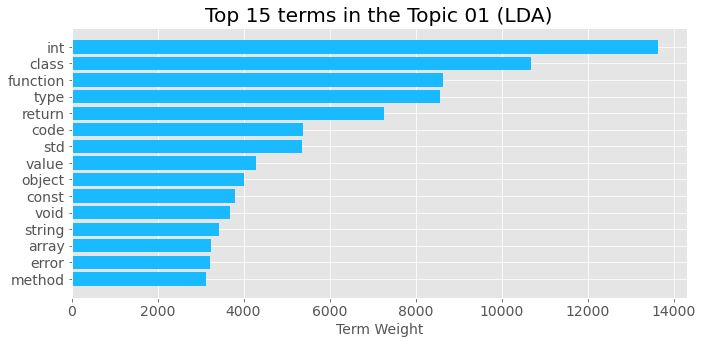

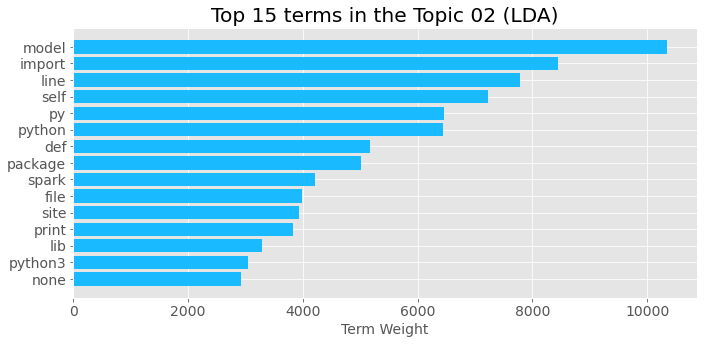

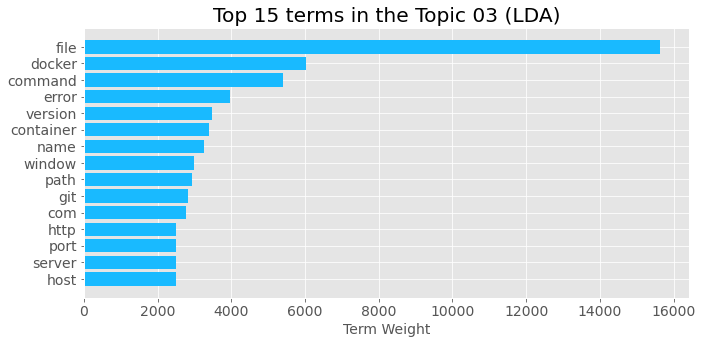

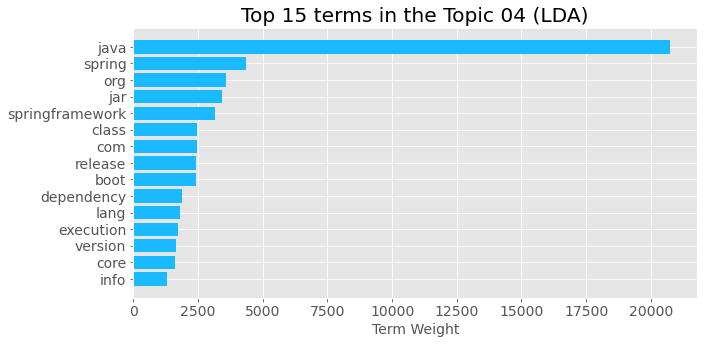

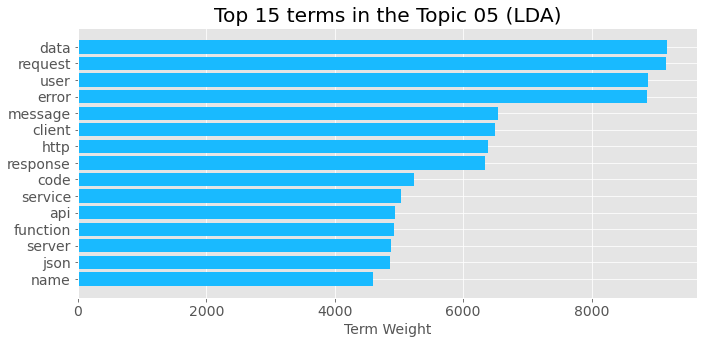

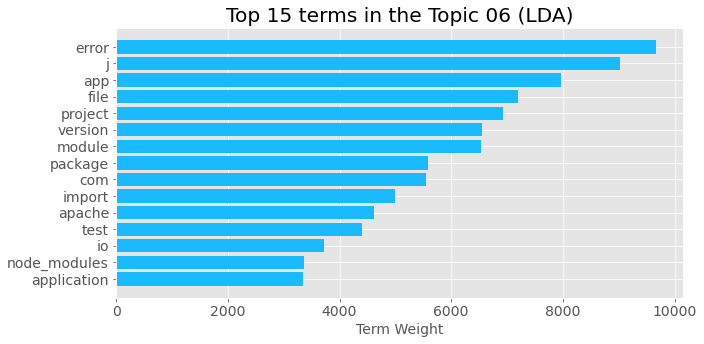

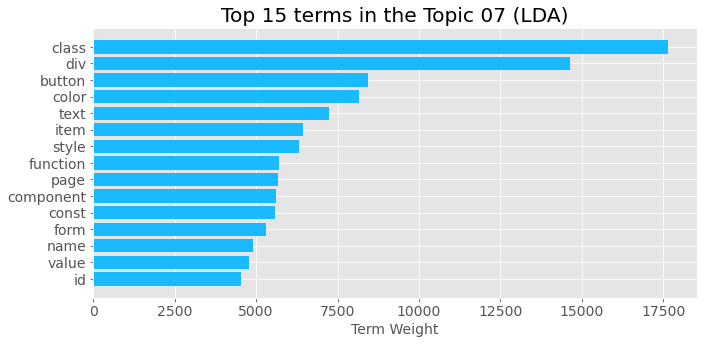

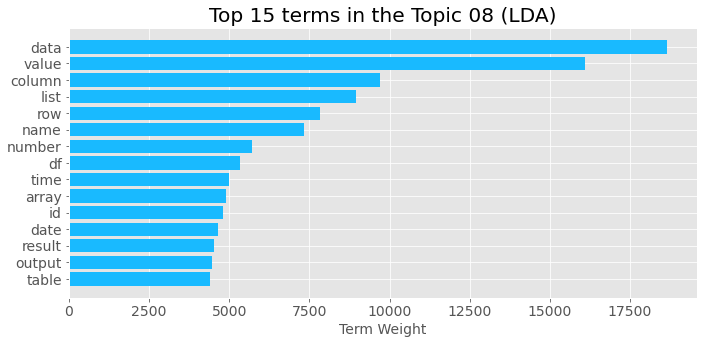

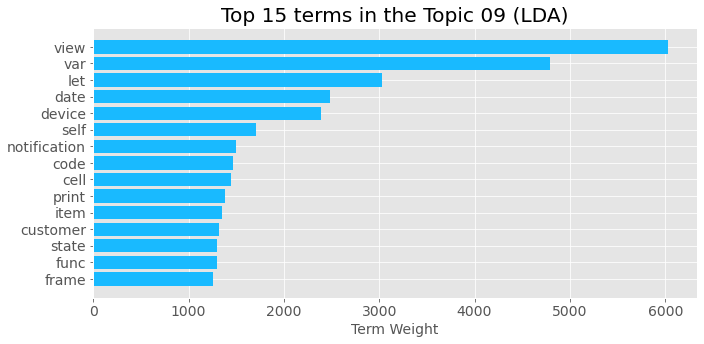

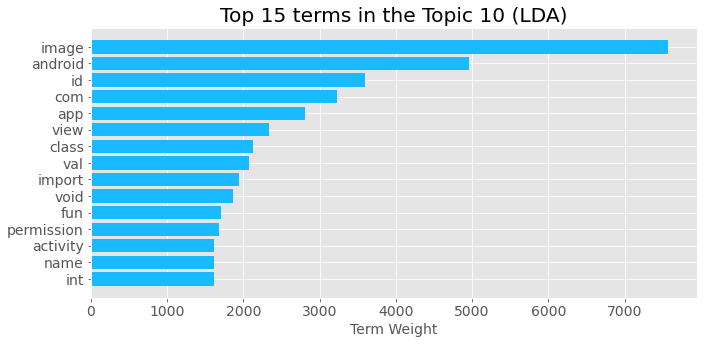

In [9]:
for i in range(k_topics):
    plot_top_term_weights(corpus_voc, lda_model_sklearn.components_, i, 15, 'LDA')

After making the reference model with scikit-learn, I discovered the gensim library, specializing in topic modeling, with a lot of interesting features, especially for the evaluation of models and visualization of detected topics

In [10]:
# compute document-term matrix from gensim
dtm_gensim = Sparse2Corpus(vstack(corpus_df['bow']), documents_columns=False)
# compute tfidf matrix from gensim
tfidf_gensim = Sparse2Corpus(vstack(corpus_df['tfidf']), documents_columns=False)

voc_gensim = Dictionary.from_corpus(dtm_gensim, id2word=dict((id, word) for word, id in bow_vectorizer.vocabulary_.items()))
# saving
joblib.dump((voc_gensim, dtm_gensim, tfidf_gensim), "P5_04_data/gensim_voc-dt-tfidf.pkl")

['P5_04_data/voc-dt-tfidf_gensim.pkl']

In [11]:
lda_params = {
    'corpus': dtm_gensim,
    'id2word': voc_gensim,
    'random_state': 0,
    'chunksize': 100,
    'per_word_topics': True
}

lda_model_gensim = LdaMulticore(num_topics=k_topics, **lda_params)

In [12]:
# Compute Perplexity
print('Perplexity: ', lda_model_gensim.log_perplexity(dtm_gensim))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model_gensim,
    # using inverse_transform() to get the reduced list of tokens
    texts=bow_vectorizer.inverse_transform(vstack(corpus_df['bow'])),
    dictionary=voc_gensim,
    coherence='c_v',
    processes=-1
)
print('Coherence Score: ', coherence_model_lda.get_coherence())

Perplexity:  -7.448685858350878
Coherence Score:  0.6374495370771437


**Optimal number of topics**

In [13]:
def compute_coherence_values(model_type, model_params, tokens, limit, start=2, step=3):
    """Compute c_v coherence for various number of topics
    args:
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
    Returns:
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    if 'num_topics' in model_params:
        del model_params['num_topics']
    models = {}
    for num_topics in range(start, limit, step):
        print(f"Testing with {num_topics:02d} topics ...", end=' ')
        if model_type == 'lda':
            model = LdaMulticore(num_topics=num_topics, **model_params)
        elif model_type == 'nmf':
            model = Nmf(num_topics=num_topics, **model_params)
        coherencemodel = CoherenceModel(
            model=model,
            texts=tokens,
            dictionary=model_params['id2word'],
            coherence='c_v',
            processes=-1
        )
        models[num_topics] = {'model': model, 'score': coherencemodel.get_coherence()}
        print(f"coherence = {coherencemodel.get_coherence():.3f}")
    return models

In [14]:
%%time

start = 2
limit = 51  # Number of differents tags + 1
step = 4

lda_models = compute_coherence_values(
    model_type='lda',
    model_params=lda_params,
    tokens=bow_vectorizer.inverse_transform(vstack(corpus_df['bow'])),
    start=start, limit=limit, step=step
)

Testing with 02 topics ... coherence = 0.621
Testing with 06 topics ... coherence = 0.637
Testing with 10 topics ... coherence = 0.645
Testing with 14 topics ... coherence = 0.650
Testing with 18 topics ... coherence = 0.613
Testing with 22 topics ... coherence = 0.607
Testing with 26 topics ... coherence = 0.601
Testing with 30 topics ... coherence = 0.584
Testing with 34 topics ... coherence = 0.564
Testing with 38 topics ... coherence = 0.591
Testing with 42 topics ... coherence = 0.551
Testing with 46 topics ... coherence = 0.532
Testing with 50 topics ... coherence = 0.547
Wall time: 24min 35s


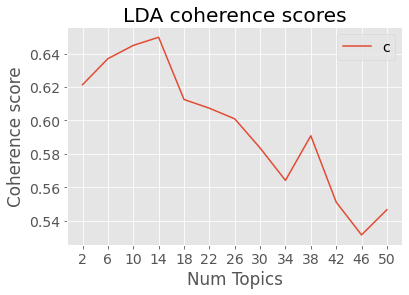

In [15]:
# Show graph
plt.plot(range(start, limit, step), [lda_models[x]['score'] for x in lda_models])
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, 4))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("LDA coherence scores")
plt.show()

In [16]:
best_nbtopics = [x for x in lda_models if lda_models[x]['score'] == max([lda_models[x]['score'] for x in lda_models])][0]
lda_params['num_topics'] = best_nbtopics

In [17]:
print(f"As we can see, the best coherence score is reached with {best_nbtopics}"
      f"topics ({lda_models[best_nbtopics]['score']}) for LDA topic modeling")

As we can see, the best coherence score is reached with 14 topics (0.6497618413038008) for LDA topic modeling


1:141: E501 line too long (150 > 140 characters)


In [18]:
lda_model_gensim = LdaMulticore(**lda_params)
lda_model_gensim = lda_models[best_nbtopics]['model']
print(f"Coherence Score for {best_nbtopics} topics: {lda_models[best_nbtopics]['score']}")

Coherence Score for 14 topics: 0.6497618413038008


In [19]:
joblib.dump(lda_model_gensim, "P5_04_data/gensim-lda.pkl")

['P5_04_data/lda-gensim.pkl']

In [20]:
for topic in lda_model_gensim.print_topics(num_topics=best_nbtopics, num_words=10):
    print(f"Topic {topic[0]+1:02d} :\n{topic[1]}\n")

Topic 01 :
0.039*"version" + 0.032*"spring" + 0.021*"dependency" + 0.021*"release" + 0.020*"springframework" + 0.018*"error" + 0.017*"boot" + 0.015*"application" + 0.014*"org" + 0.012*"class"

Topic 02 :
0.021*"request" + 0.016*"function" + 0.014*"user" + 0.013*"code" + 0.013*"error" + 0.012*"class" + 0.012*"system" + 0.011*"method" + 0.011*"service" + 0.011*"api"

Topic 03 :
0.026*"image" + 0.023*"docker" + 0.018*"code" + 0.015*"command" + 0.014*"window" + 0.013*"version" + 0.010*"error" + 0.010*"container" + 0.009*"python" + 0.009*"way"

Topic 04 :
0.058*"div" + 0.051*"class" + 0.020*"image" + 0.020*"color" + 0.018*"button" + 0.018*"text" + 0.018*"style" + 0.013*"html" + 0.010*"cs" + 0.010*"position"

Topic 05 :
0.030*"model" + 0.025*"data" + 0.022*"column" + 0.020*"value" + 0.017*"time" + 0.017*"df" + 0.014*"row" + 0.013*"output" + 0.013*"import" + 0.012*"dataframe"

Topic 06 :
0.047*"file" + 0.027*"package" + 0.023*"module" + 0.022*"error" + 0.020*"j" + 0.020*"py" + 0.018*"line" + 

In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [22]:
pyLDAvis.enable_notebook()
lda_visu = gensimvis.prepare(lda_model_gensim, dtm_gensim, voc_gensim)

In [23]:
# This visualization is breaking my jupter notebook so I display it only if needed
if DISPLAY_LDA_VISU:
    lda_visu

In [24]:
pyLDAvis.save_html(lda_visu, "P5_04_data/visualizations-LDA.html")
pyLDAvis.disable_notebook()

In [25]:
colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]

In [26]:
def display_wordcloud(model, title, plot_format=(2, 3), size=(10, 15), nb_words=10):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=2000,
                      max_words=nb_words,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(num_topics=model.num_topics, formatted=False)

    fig, axes = plt.subplots(plot_format[0], plot_format[1], figsize=size, sharex=True, sharey=True)
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title(f'Topic {i:02d}', fontdict=dict(size=16))
            plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=10, y=10)
    plt.tight_layout()
    plt.show()

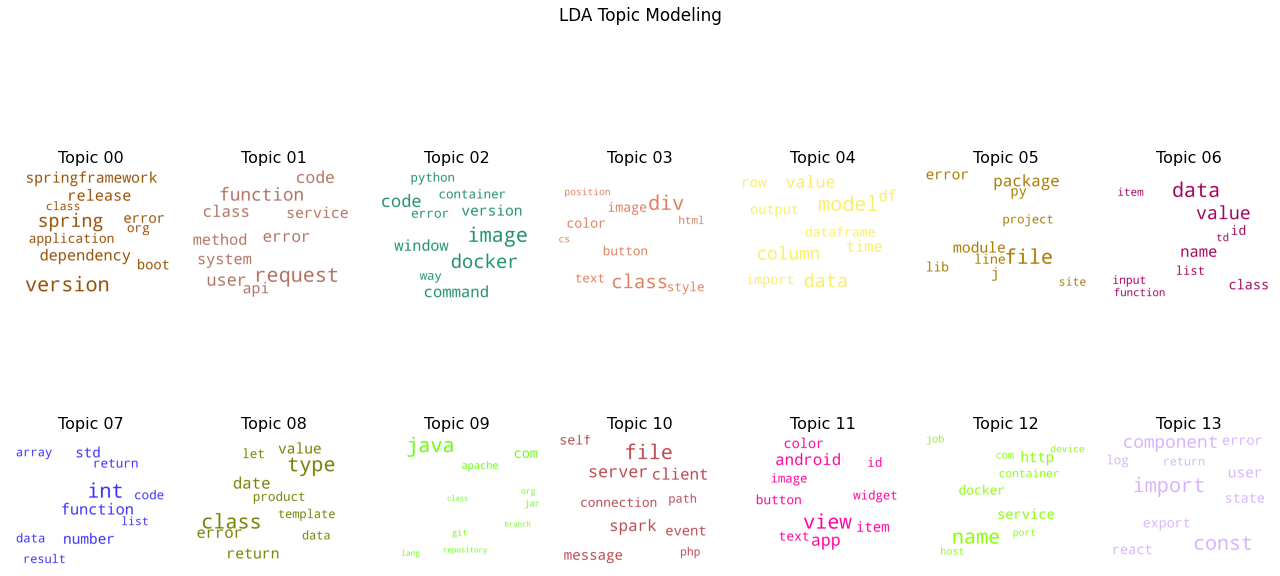

In [111]:
display_wordcloud(lda_model_gensim, title='LDA Topic Modeling', plot_format=(2, 7), size=(18, 10), nb_words=10)

#### NMF

NMF produces two factor matrices as its output, **W** and **H** :
- The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.
- The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

**Baseline**  
Using the same number of topics as the tuned LDA

In [28]:
# same number of topics as LDA for baseline
nmf_params = {
    'corpus': tfidf_gensim,
    'num_topics': lda_params['num_topics'],
    'id2word': voc_gensim,
    'chunksize': 100,
    'eval_every': 10,
    'normalize': True,
    'random_state': 0
}

nmf_model_gensim = Nmf(**nmf_params)

In [29]:
# Compute Coherence Score
coherence_model_nmf = CoherenceModel(
    model=nmf_model_gensim,
    texts=bow_vectorizer.inverse_transform(vstack(corpus_df['tfidf'])),
    dictionary=voc_gensim,
    coherence='c_v',
    processes=-1
)
print('Coherence Score: ', coherence_model_nmf.get_coherence())

Coherence Score:  0.6109670732476193


**Optimal number of topics**

In [30]:
%%time
# searching a better number of topics for NMF modeling
nmf_models = compute_coherence_values(
    model_type='nmf',
    model_params=nmf_params,
    tokens=bow_vectorizer.inverse_transform(vstack(corpus_df['tfidf'])),
    start=start, limit=limit, step=step
)

Testing with 02 topics ... coherence = 0.657
Testing with 06 topics ... coherence = 0.658
Testing with 10 topics ... coherence = 0.644
Testing with 14 topics ... coherence = 0.611
Testing with 18 topics ... coherence = 0.630
Testing with 22 topics ... coherence = 0.639
Testing with 26 topics ... coherence = 0.644
Testing with 30 topics ... coherence = 0.622
Testing with 34 topics ... coherence = 0.624
Testing with 38 topics ... coherence = 0.600
Testing with 42 topics ... coherence = 0.613
Testing with 46 topics ... coherence = 0.605
Testing with 50 topics ... coherence = 0.614
Wall time: 30min 41s


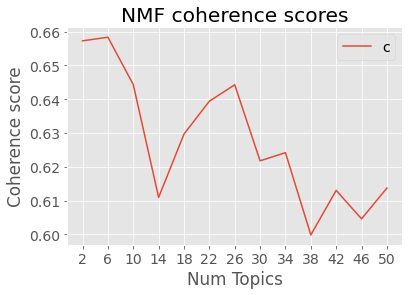

In [31]:
# Show graph
plt.plot(range(start, limit, step), [nmf_models[x]['score'] for x in nmf_models])
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, step))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("NMF coherence scores")
plt.show()

In [32]:
best_nbtopics = [x for x in nmf_models if nmf_models[x]['score'] == max([nmf_models[x]['score'] for x in nmf_models])][0]
nmf_params['num_topics'] = best_nbtopics
print(f"As we can see, the best coherence score is reached with {best_nbtopics} topics for NMF topic modeling")

As we can see, the best coherence score is reached with 6 topics for NMF topic modeling


In [33]:
nmf_model_gensim = nmf_models[best_nbtopics]['model']
print(f"Coherence Score for {best_nbtopics} topics: {nmf_models[best_nbtopics]['score']}")

Coherence Score for 6 topics: 0.6583530134886656


In [34]:
# Saving NMF model
joblib.dump(nmf_model_gensim, "P5_04_data/gensim-nmf.pkl")

['P5_04_data/nmf-gensim.pkl']

In [35]:
for topic in nmf_model_gensim.print_topics(num_topics=best_nbtopics, num_words=10):
    print(f"Topic {topic[0]:02d} :\n{topic[1]}\n")

Topic 00 :
0.028*"java" + 0.025*"item" + 0.010*"com" + 0.010*"android" + 0.009*"list" + 0.008*"view" + 0.007*"name" + 0.006*"version" + 0.006*"id" + 0.005*"spring"

Topic 01 :
0.034*"value" + 0.024*"array" + 0.021*"int" + 0.018*"list" + 0.015*"function" + 0.014*"number" + 0.010*"type" + 0.009*"return" + 0.008*"element" + 0.008*"result"

Topic 02 :
0.036*"column" + 0.027*"data" + 0.022*"row" + 0.021*"df" + 0.020*"image" + 0.017*"date" + 0.017*"dataframe" + 0.012*"frame" + 0.010*"color" + 0.009*"value"

Topic 03 :
0.017*"j" + 0.016*"app" + 0.012*"error" + 0.009*"const" + 0.009*"component" + 0.008*"import" + 0.008*"react" + 0.007*"module" + 0.007*"http" + 0.007*"project"

Topic 04 :
0.043*"file" + 0.016*"line" + 0.015*"package" + 0.012*"py" + 0.012*"python" + 0.009*"error" + 0.008*"site" + 0.008*"lib" + 0.008*"user" + 0.007*"import"

Topic 05 :
0.035*"class" + 0.030*"div" + 0.013*"data" + 0.012*"button" + 0.011*"form" + 0.010*"function" + 0.009*"text" + 0.008*"type" + 0.008*"model" + 0.00

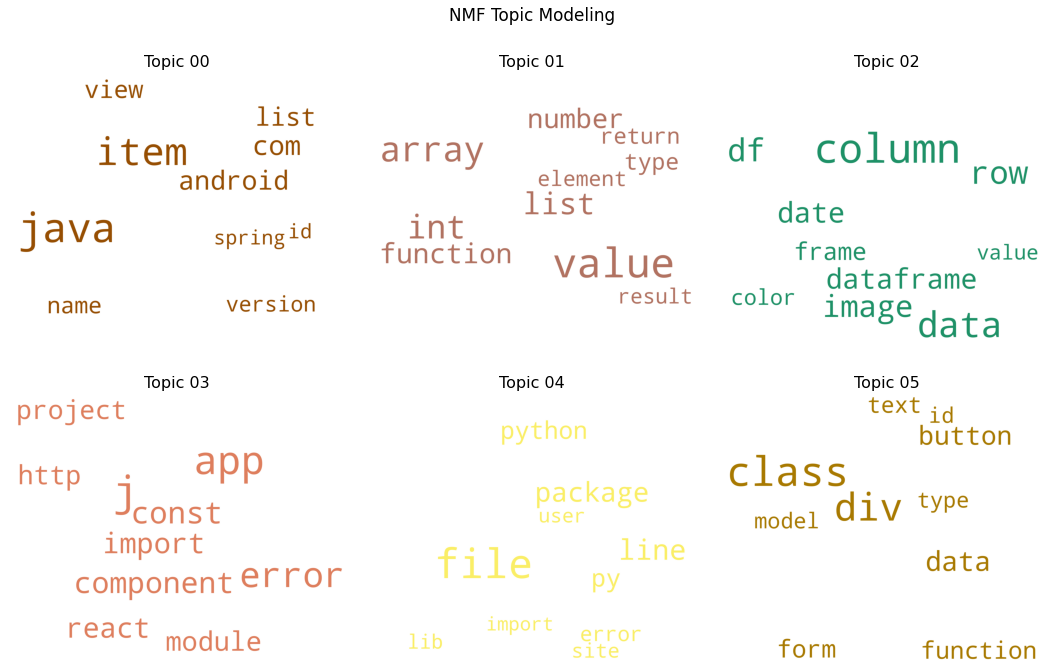

In [110]:
shuffle(colors_list)  # if a topic is hard to read
display_wordcloud(nmf_model_gensim, title='NMF Topic Modeling', plot_format=(2, 3), size=(15, 10), nb_words=10)

**The best coherence score is obtained with NMF topics modeling and 18 topics**

In [37]:
%%time
# assign topics to each doc
corpus_df['topics'] = [nmf_model_gensim.get_document_topics(bow, minimum_probability=None, normalize=None) for bow in dtm_gensim]
# remove probability from the topics
corpus_df['topics'] = corpus_df['topics'].apply(lambda x: [topic[0] for topic in x])

Wall time: 54.9 s


In [38]:
# saving dataset with computed topics
joblib.dump(corpus_df, "P5_04_data/dataset.pkl")

['P5_04_data/dataset.pkl']

In [39]:
mlb_topics = MultiLabelBinarizer()
mlb_topics.fit(corpus_df['topics'])
binary_topics = pd.DataFrame(mlb_topics.transform(corpus_df['topics']), columns=mlb_topics.classes_)

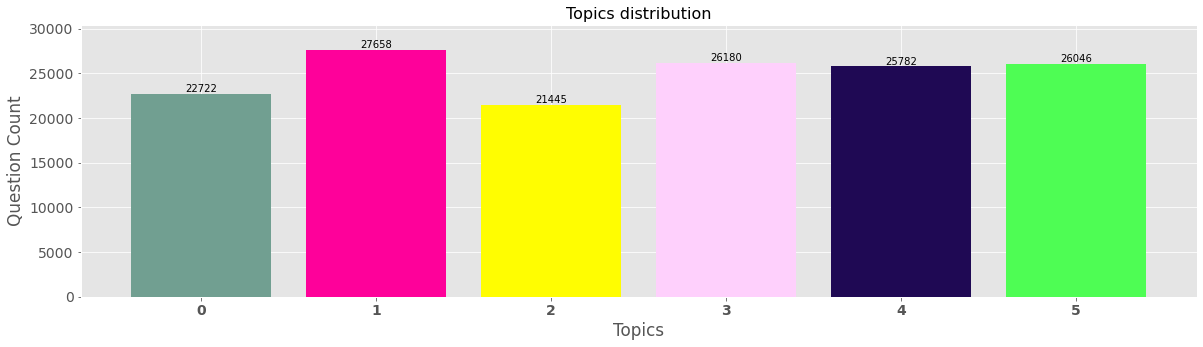

In [40]:
f, ax = plt.subplots(figsize=(20, 5))
values = binary_topics.sum()
plt.bar(x=binary_topics.columns, height=values, color=colors_list)
plt.title('Topics distribution', fontsize=16)
plt.xticks(binary_topics.columns, fontsize=14, fontweight='bold')
plt.xlabel('Topics')
plt.ylabel('Question Count')
# adding the text labels
rects = ax.patches
plt.ylim((0, max(values)+max(values)/10))
for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, val, ha='center', va='bottom', fontsize=10)
plt.show()

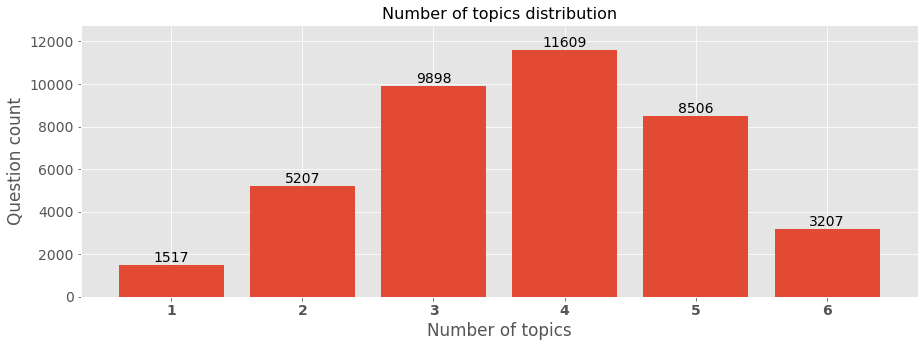

In [41]:
from collections import Counter

nbtopic_distrib = sorted(dict(Counter([len(x) for x in corpus_df['topics']])).items())
nbtopic = [x[0] for x in nbtopic_distrib]
values = [x[1] for x in nbtopic_distrib]

f, ax = plt.subplots(figsize=(15, 5))
plt.bar(x=nbtopic, height=values)
plt.title('Number of topics distribution', fontsize=16)
plt.xticks(nbtopic, fontsize=14, fontweight='bold')
plt.xlabel('Number of topics')
plt.ylabel('Question count')
# adding the text labels
rects = ax.patches

plt.ylim((0, max(values)+max(values)/10))
for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, val, ha='center', va='bottom', fontsize=14)
plt.show()

### topics / tags association

In [80]:
# outputs binarization
mlb_tags = MultiLabelBinarizer()
mlb_tags.fit(corpus_df['reduced_tags'])

MultiLabelBinarizer()

By multiplying the questions/topics matrix by the tags / questions matrix, its possible to obtain a tags/topics matrix which, once normalized by topics, represents the probability of each tags to belong to a topic

In [43]:
tag_doc_matrix = mlb_tags.transform(corpus_df['reduced_tags']).T
print("tag/doc matrix:", tag_doc_matrix.shape)

doc_topic_matrix = np.array(binary_topics.copy())
print("doc/topic matrix:", doc_topic_matrix.shape)


tag/doc matrix: (50, 39944)
doc/topic matrix: (39944, 6)


In [44]:
tag_topic_matrix = np.matmul(tag_doc_matrix, doc_topic_matrix)
print("tag/topic matrix:", tag_topic_matrix.shape)

tag/topic matrix: (50, 6)


In [45]:
# normalization by topics
tag_topic_matrix_norm = (tag_topic_matrix / tag_topic_matrix.sum(axis=0))

Then by multiplying this tags/topics matrix by the topic distribution of the questions, we obtain the distribution of tags for each each question.

In [47]:
doc_tag_matrix = pd.DataFrame(
    np.matmul(tag_topic_matrix_norm, doc_topic_matrix.T),
    columns=corpus_df.index,
    index=mlb_tags.classes_
)
print("doc/tag matrix:", doc_tag_matrix.shape)

doc/tag matrix: (50, 39944)


In [48]:
corpus_df['topics_deducted_tags'] = doc_tag_matrix.idxmax(axis=0)

In [49]:
corpus_df['topics_deducted_tags'].unique()

array(['python', 'java'], dtype=object)

In [17]:
corpus_df.head(2)

,doc,tags,tags_cnt,reduced_tags,reduced_tags_cnt,tokens,tokens_cnt,bow,tfidf,topics
id,,,,,,,,,,
65526356,"Pyspark + Graphframes: ""recursive"" message agg...","[python, apache-spark, pyspark, apache-spark-s...",5,"[python, apache-spark]",2,"[Pyspark, Graphframes, message, aggregation, g...",72,"(0, 12699)\t1\n (0, 6999)\t1\n (0, 9954)\t...","(0, 11581)\t0.0588952789627034\n (0, 14701)...","[1, 2]"
65526323,Set if conditions based on radio input value ...,"[javascript, jquery]",2,"[javascript, jquery]",2,"[Set, condition, radio, input, value, radio, i...",125,"(0, 7653)\t3\n (0, 10595)\t3\n (0, 17079)\...","(0, 9762)\t0.051351916891175374\n (0, 2659)...","[1, 5]"


## Method 2 : supervised classification

In [14]:
X = corpus_df['doc']
mlb_tags = MultiLabelBinarizer()
y = mlb_tags.fit_transform(corpus_df['reduced_tags'])

In [15]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.33, shuffle=True)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(26762,) (26762, 50) (13182,) (13182, 50)


In [19]:
%%time
# Inputs vectorization
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_test_vect = tfidf_vectorizer.transform(X_test)
joblib.dump((tfidf_vectorizer, mlb_tags), "P5_04_data/trainset-io-vectorizers.pkl")

Wall time: 11min 48s


['P5_04_data/trainset-io-vectorizers.pkl']

In [21]:
print(X_train_vect.shape, X_test_vect.shape)


(26762, 13264) (13182, 13264)


In [20]:
train_tfidf_vectorizer, mlb_tags = joblib.load("P5_04_data/trainset-io-vectorizers.pkl")

### One Vs Rest

Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).
In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.  
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

**Baseline**

In [19]:
%%time
# Using pipeline for applying logistic regression and one vs rest classifier
ovr_lr_base = OneVsRestClassifier(LogisticRegression(solver='sag', random_state=0), n_jobs=-1)
ovr_lr_base.fit(X_train_vect, y_train)

ovr_preds = ovr_lr_base.predict(X_test_vect)

print("Baseline OneVsRestClassifier on testset :")
print(f"F1={f1_score(y_test, ovr_preds, average='weighted'):.3f} - Jaccard={jaccard_score(y_test, ovr_preds, average='weighted'):.3f}")

Baseline OneVsRestClassifier on testset :
F1=0.547 - Jaccard=0.397
Wall time: 6.99 s


In [20]:
print(classification_report(y_test, ovr_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.71      0.16      0.26       183
           1       0.90      0.29      0.44       264
           2       0.90      0.48      0.63       786
           3       0.93      0.19      0.31       301
           4       0.91      0.47      0.62       161
           5       0.54      0.18      0.27       208
           6       0.77      0.15      0.26       150
           7       0.88      0.45      0.59       190
           8       0.74      0.21      0.32       194
           9       0.81      0.27      0.41       579
          10       0.93      0.56      0.70       730
          11       0.81      0.43      0.56       372
          12       0.49      0.18      0.26       242
          13       0.52      0.12      0.20       280
          14       0.97      0.47      0.63       221
          15       0.96      0.67      0.79       376
          16       0.81      0.28      0.41       253
          17       0.81    

**Optimizations**

In [34]:
# used scoring metric
metrics = ['f1_weighted', 'jaccard_weighted']


def gs_tuning(classifier, params_grid, trainset=(X_train_vect, y_train), testset=(X_test_vect, y_test),  metrics=metrics, save=True):
    """
    args:
        classifier (obj) - classifier to optimize
        params_grid (dict) - tested parameters
        trainset (tuple) - X_train, y_train in a tuple
        testset (tuple) - X_test, y_test in a tuple
        metric (list or str) - scoring metrics
        save (bool) - save best model if True
    returns:
        best_model (obj) - tuned model
        preds (list) - best model predictions
    """
    gd = GridSearchCV(classifier, params_grid, scoring=metrics, refit=metrics[0], return_train_score=True, n_jobs=-1)
    gd.fit(trainset[0], trainset[1])
    print(f"Best params: {gd.best_params_}")
    print(f"Best training F1: {gd.best_score_}")
    preds = gd.predict(testset[0])
    print(f"Scores on testset: F1={f1_score(testset[1], preds, average='weighted'):.3f}"
          f" - Jaccard={jaccard_score(testset[1], preds, average='weighted'):.3f}\n")
    print(classification_report(testset[1], preds, zero_division=0))
    if save:
        joblib.dump(gd.best_estimator_, f"P5_04_data/model-{classifier.__class__.__name__}-tuned.pkl")
    return gd.best_estimator_, preds


In [35]:
# disable warning for bad combinaisons in the GridSearch
warnings.filterwarnings('ignore')

In [36]:
%%time
### OneVsRestClassifier using LogisticRegression ###
ovr_lr_params = {
    'estimator__solver': ['sag', 'saga'],  # faster on large dataset
    'estimator__C': [0.1, 1, 10],
    'estimator__penalty': ['l1', 'l2', None],
    'estimator__max_iter': [100, 200],
}

tuned_ovr_lr, ovr_preds = gs_tuning(OneVsRestClassifier(LogisticRegression()), ovr_lr_params)

Best params: {'estimator__C': 10, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
Best training F1: 0.6532237880941179
Scores on testsset: F1=0.662 - Jaccard=0.515

              precision    recall  f1-score   support

           0       0.56      0.41      0.47       183
           1       0.81      0.61      0.70       264
           2       0.85      0.66      0.74       786
           3       0.80      0.49      0.61       301
           4       0.87      0.65      0.74       161
           5       0.39      0.19      0.26       208
           6       0.60      0.41      0.49       150
           7       0.78      0.63      0.70       190
           8       0.65      0.46      0.54       194
           9       0.76      0.54      0.63       579
          10       0.87      0.73      0.79       730
          11       0.71      0.61      0.66       372
          12       0.49      0.34      0.40       242
          13       0.46      0.24      0.

In [33]:
# tuned_ovr_lr = joblib.load("P5_04_data/model-OneVsRestClassifier-tuned.pkl")
# tuned_ovr_lr.predict(X_test_vect)

### Classifier Chain

A chain of binary classifiers C_0, C_1, . . . , C_n is constructed, where a classifier C_i uses the predictions of all the classifier C_j , where j < i.   
This way the classifier chains method can take into account label correlations.  
The total number of classifiers needed for this approach is equal to the number of classes, but the training of the classifiers is more involved. 

**Baseline**

In [16]:
%%time
# classifier chains multi-label classifier
cc_lr_base = ClassifierChain(LogisticRegression(
    solver='saga',
    C=10,
    penalty='l1',
    max_iter=100,
    n_jobs=-1,
    random_state=0
))
cc_lr_base.fit(X_train_vect, y_train)
# predict
cc_preds = cc_lr_base.predict(X_test_vect)

print(f"ClassifierChain on testset : F1={f1_score(y_test, cc_preds, average='weighted'):.3f}"
      f" - Jaccard={jaccard_score(y_test, cc_preds, average='weighted'):.3f}")
joblib.dump(cc_lr_base, "P5_04_data/model-ClassifierChain.pkl")

I directly use the same parameters as for the previous tuned LogisticRegression because the optimization by GridSearch of the ClassifierChain requires too much time and memory.

**Optimizations**

In [ ]:
%%time
# ClassifierChain using LogisticRegression
cc_lr_params = {
    'classifier__solver': ['sag', 'saga'],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__max_iter': [100, 200],
}

# tuned_cc_lr, cc_preds = gs_tuning(ClassifierChain(LogisticRegression()), cc_lr_params)

In [ ]:
# re-enbale warnings
warnings.filterwarnings('always')

### Universal Sentence Encoder tests

In [ ]:
import tensorflow_hub as hub

use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = use_model([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

In [125]:
embeddings = use_model(corpus_df['doc'])

NameError: name 'use_model' is not defined